# Food Safety Analysis

This is an exploration of restaurant food safety scores for restaurants in San Francisco as of September 24, 2021.
Data made available by the San Francisco Department of Public Health.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

import os

### File Systems and I/O

In [3]:
from pathlib import Path
data_dir = Path('.')
data_dir.mkdir(exist_ok = True)
file_path = data_dir / Path('data.zip')
dest_path = file_path

### Reading in the data

In [4]:
data_dir = Path('.')
dsDir = Path('data')
bus = pd.read_csv(dsDir.joinpath('bus.csv'), encoding = 'ISO-8859-1')
ins2vio = pd.read_csv(dsDir.joinpath('ins2vio.csv'))
ins = pd.read_csv(dsDir.joinpath('ins.csv'))
vio = pd.read_csv(dsDir.joinpath('vio.csv'))

In [5]:
display(bus.head(5), ins.head(5), vio.head(5), ins2vio.head(5))

,business_id,name,address,city,state,postal code,latitude,longitude,phone_number
0,835,Kam Po Kitchen,801 Broadway St,San Francisco,CA,94133,37.797223,-122.410513,NaN
1,905,Working Girls' Cafe',0259 Kearny St,San Francisco,CA,94108,37.790477,-122.404033,NaN
2,1203,TAWAN'S THAI FOOD,4403 GEARY Blvd,San Francisco,CA,94118,37.780834,-122.466590,1.415576e+10
3,1345,Cordon Bleu,1574 California St,San Francisco,CA,94109,37.790683,-122.420264,NaN
4,1352,LA TORTILLA,495 Castro St B,San Francisco,CA,94114,37.760954,-122.434935,1.415586e+10


,iid,date,score,type
0,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled
1,905_20190415,4/15/19 0:00,87.0,Routine - Unscheduled
2,1203_20170803,8/3/17 0:00,77.0,Routine - Unscheduled
3,1345_20170928,9/28/17 0:00,81.0,Routine - Unscheduled
4,1352_20180620,6/20/18 0:00,74.0,Routine - Unscheduled


,description,risk_category,vid
0,Improper food storage,Low Risk,835_20180917_103139
1,High risk vermin infestation,High Risk,905_20190415_103114
2,Moderate risk food holding temperature,Moderate Risk,1203_20170803_103120
3,Improper cooling methods,High Risk,1345_20170928_103105
4,Non service animal,Low Risk,1352_20180620_103177


,iid,vid
0,835_20180917,835_20180917_103139
1,905_20190415,905_20190415_103114
2,1203_20170803,1203_20170803_103120
3,1345_20170928,1345_20170928_103105
4,1352_20180620,1352_20180620_103177


#### 'iid' = inspection id, 'vid' = violation id

### Cleaning the data

In [6]:
bus['phone_number'] = bus['phone_number'].fillna(value = '-9999')
bus['latitude'] = bus['latitude'].fillna(value = '-9999')
bus['longitude'] = bus['longitude'].fillna(value = '-9999')
bus['postal code'] = bus['postal code'].fillna(value = '-9999')
ins['score'] = ins['score'].fillna(value = '-1')


In [7]:
bus = bus.rename(columns ={'business_id': 'bid'})

### Examining the data

In [8]:
is_bid_unique = (len(bus['bid'].unique()) == bus.shape[0])
is_bid_unique #are the businesses unique in the dataset

False

In [9]:
name_counts = bus['name'].value_counts()
name_counts.head(10) #number of records per business name

Peet's Coffee & Tea         151
McDonald's                  110
Whole Foods Market           97
Jamba Juice                  83
Mixt Greens/Mixt             81
Pakwan Restaurant            81
Henry's Hunan Restaurant     72
Lee's Deli                   70
Quickly                      64
Starbucks Coffee             64
Name: name, dtype: int64

In [10]:
address_counts = bus['address'].value_counts()
address_counts.head(10) #number of records per address

428 11th St                   200
Off The Grid                  199
3251 20th Ave                 107
24 Willie Mays Plaza           66
1355 Market St                 66
1 Market St                    59
Off the Grid                   58
Pier 41                        55
601 Mission Bay Blvd North     50
2300 16th St                   50
Name: address, dtype: int64

## Cleaning the Business Data Postal Codes

Using the postal code information to aggregate the ratings over regions of the city. The postal code (ZIP code) partitions the city into regions:
<img src="https://www.usmapguide.com/wp-content/uploads/2019/03/printable-san-francisco-zip-code-map.jpg" alt="ZIP Code Map" style="width: 600px">

In [11]:
zip_counts = bus['postal code'].value_counts()
zip_counts.head(10)

94110    5921
94103    4868
94102    3789
94109    3692
94133    3325
94107    2718
94118    2633
94112    2333
94122    2158
94105    2104
Name: postal code, dtype: int64

In [12]:
valid_zips = pd.read_json('data/sf_zipcodes.json',dtype = 'str')['zip_codes'] 
#series of valid ZIP codes in the data to make examination easier

In [13]:
#examine the invalid ZIP codes in the data
invalid_zip_bus = bus[~(bus['postal code'].isin(valid_zips))]
invalid_zip_bus.head(10)

,bid,name,address,city,state,postal code,latitude,longitude,phone_number
16,38146,San Pancho's Tacos,491 Bayshore St,San Francisco,CA,-9999,-9999,-9999,14155271520.0
20,64738,Japacurry,Public,San Francisco,CA,CA,37.777122,-122.419639,-9999
37,70779,Davids Tea,845 Market St #13,San Francisco,CA,-9999,-9999,-9999,-9999
42,74869,Sabrosa,3200 Fillmore St,San Francisco,CA,-9999,-9999,-9999,-9999
44,76784,Capital Restaurant,839 Clay,San Francisco,CA,-9999,-9999,-9999,-9999
57,80405,Liholiho Yacht Club,871 Sutter St,San Francisco,CA,-9999,-9999,-9999,-9999
58,80620,Cafe 55,55 Stockton St,San Francisco,CA,-9999,-9999,-9999,14155977688.0
65,82880,Don Pablo,Off The Grid,San Francisco,CA,-9999,-9999,-9999,-9999
66,83636,Sam's Chowder Mobile #4,Off The Grid,San Francisco,CA,-9999,-9999,-9999,-9999
80,88155,Limon Rotisserie,Off The Grid,San Francisco,CA,-9999,-9999,-9999,-9999


In [14]:
#check for commonalities among invalid postal codes
missing_zip_address_count = invalid_zip_bus[invalid_zip_bus['postal code'] == '-9999']['address'].value_counts()
missing_zip_address_count.head()

Off The Grid        199
Off the Grid         55
1717 Harrison St     27
625 Clement St       25
842 Geary St         25
Name: address, dtype: int64

If these businesses were to be dropped from analysis, samller businesses would not be properly represented in this analysis. 

## Investigating the Inspection Data

In [15]:
#check that all the inspection id in ins table are unique
ins['iid'].is_unique

False

In [23]:
#remove any duplicate rows 
ins = ins.drop_duplicates()

In [24]:
ins['iid'].is_unique

True

For the iid column in the inspection table, the first 3 numbers seem to correlate to the business id. I then want to add a business id column to the inspection table for easier manipulation later.

In [25]:
ins['bid'] = ins['iid'].str.split('_')
ins['bid'] = pd.DataFrame(ins.bid.tolist(), index = ins.index)
ins['bid'] = ins['bid'].astype(int)

In [27]:
#check that the business id's are valid 
invalid_bid_count =  sum(~(ins['bid'].isin(bus['bid'])))
invalid_bid_count

0

Edit the date column in the inspection table into a Timestamp object for easier manipulation. 

In [28]:
ins['timestamp'] = pd.to_datetime(ins['date'])

In [29]:
#Find earliest and latest dates in the inspection data
earliest_date = min(ins['timestamp'])
latest_date = max(ins['timestamp'])
print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-10-04 00:00:00
Latest Date: 2019-11-28 00:00:00


In [30]:
#create a year column in the inspection table
ins['year'] = ins['timestamp'].dt.year

Look at inspection trends over the years.

In [31]:
ins_pivot = pd.pivot_table(ins[['type','year']], index = 'type', columns = 'year', aggfunc = len, fill_value = 0)

ins_pivot['Total'] = ins_pivot.sum(axis = 1)
ins_pivot_sorted = ins_pivot.sort_values('Total', ascending = False)

ins_pivot_sorted

year,2016,2017,2018,2019,Total
type,,,,,
Routine - Unscheduled,966,4057,4373,4681,14077
Reinspection/Followup,445,1767,1935,2292,6439
New Ownership,99,506,528,459,1592
Complaint,91,418,512,437,1458
New Construction,102,485,218,189,994
Non-inspection site visit,51,276,253,231,811
New Ownership - Followup,0,45,219,235,499
Structural Inspection,1,153,50,190,394
Complaint Reinspection/Followup,19,68,70,70,227


Examine the inspection scores

In [32]:
ins['score'].value_counts().head()

-1       12632
100.0     1993
96.0      1681
92.0      1260
94.0      1250
Name: score, dtype: int64

In [42]:
#check which types of routines the score -1 is assigned to
ins['Missing Score'] = pd.to_numeric(ins['score']) == -1
ins_missing_score_pivot = pd.pivot_table(ins[['type','Missing Score']], index = 'type', columns = 'Missing Score', aggfunc = len, fill_value = 0)
ins_missing_score_pivot['Total'] = ins_missing_score_pivot.sum(axis = 1)
ins_missing_score_pivot.sort_values('Total',ascending = False)

Missing Score,False,True,Total
type,,,
Routine - Unscheduled,14031,46,14077
Reinspection/Followup,0,6439,6439
New Ownership,0,1592,1592
Complaint,0,1458,1458
New Construction,0,994,994
Non-inspection site visit,0,811,811
New Ownership - Followup,0,499,499
Structural Inspection,0,394,394
Complaint Reinspection/Followup,0,227,227


Observe that there are -1 scores only for the Routine-Unscheduled inspections. 

## Joining the data

In [56]:
temp = pd.to_numeric(ins['score'])
ins['score'] = temp

In [57]:
#Adding the name and address of the business to the inspection table
ins_named = pd.merge(ins, bus[['bid','name','address']], how = 'left', on = 'bid' )
ins_named.head(5)

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
1,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
2,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
3,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
4,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St


Examine the twenty lowest inspection scoring busninesses.

In [58]:
ins_filter = ins_named[~(ins_named['score'] == -1)]
twenty_lowest_scoring = ins_filter[['bid','name', 'score']].groupby(['bid','name'], as_index = False).agg({'score': [np.median]})
twenty_lowest_scoring.columns =  ["".join(x) for x in twenty_lowest_scoring.columns.ravel()]
twenty_lowest_scoring = twenty_lowest_scoring.rename(columns = {'scoremedian': 'median score'}).sort_values('median score')
twenty_lowest_scoring = twenty_lowest_scoring.iloc[0:20,:]
twenty_lowest_scoring

<ipython-input-58-8b75a6fa4b13>:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  twenty_lowest_scoring.columns =  ["".join(x) for x in twenty_lowest_scoring.columns.ravel()]


,bid,name,median score
3876,84590,Chaat Corner,54.0
4564,90622,Taqueria Lolita,57.0
4990,94351,VBowls LLC,58.0
2719,69282,New Jumbo Seafood Restaurant,60.5
222,1154,SUNFLOWER RESTAURANT,63.5
1991,39776,Duc Loi Supermarket,64.0
2734,69397,Minna SF Group LLC,64.0
4870,93150,Chez Beesen,64.0
4911,93502,Smoky Man,64.0
3291,78328,Golden Wok,64.0


Examine the descriptions of the violations for inspections with scores between 0 and 65. 

In [59]:
ins_filtered = ins[ (ins['score'] > 0) & (ins['score'] < 65) ]
ins_need = ins_filtered[['iid','score']]
vio_need = vio[['description','vid']]
mer1 = pd.merge(ins_need, ins2vio, how = 'inner', on = 'iid')
mer2 = pd.merge(mer1, vio_need, how = 'inner', on = 'vid')

low_score_violations = mer2['description'].value_counts()

low_score_violations.head(20)

Unclean or unsanitary food contact surfaces                                  43
High risk food holding temperature                                           42
Unclean or degraded floors walls or ceilings                                 40
Unapproved or unmaintained equipment or utensils                             39
High risk vermin infestation                                                 37
Foods not protected from contamination                                       37
Inadequate food safety knowledge or lack of certified food safety manager    35
Inadequate and inaccessible handwashing facilities                           35
Improper thawing methods                                                     30
Unclean hands or improper use of gloves                                      27
Improper cooling methods                                                     25
Unclean nonfood contact surfaces                                             21
Improper food storage                   

### Explore the Inspection Scores

Text(0.5, 1.0, 'Distribution of Inspection Scores')

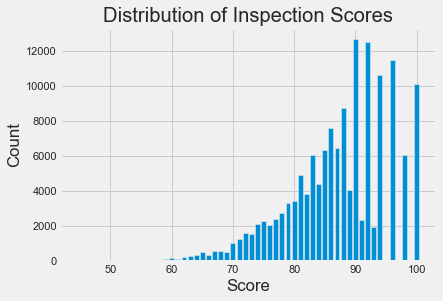

In [60]:
#Distribution of the inspection scores 
values = ins_filter['score'].value_counts().keys().tolist()
counts = ins_filter['score'].value_counts().tolist()
plt.bar(values, counts)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Inspection Scores')

The mode of the inspection scores is 100, meaning perfect scores made up the largest proportion of inspection scores. Ths distribution of the inspection scores in not symmetrical and negatively skewed with a left tail. There are also no observations or significantly less scores in the gaps near the higher end of the distribution. I can infer that most violations dock more the one point. 

In [61]:
#Add business id and address to inspection table but set to NaN if business doesn't exist.
ins_named = pd.merge(ins, bus[['bid','name','address']], how = 'left', on = 'bid' )
ins_named.head()

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
1,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
2,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
3,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St
4,835_20180917,9/17/18 0:00,88.0,Routine - Unscheduled,835,2018-09-17,2018,False,Kam Po Kitchen,801 Broadway St


In [64]:
#Find the worst scored restaurant
sorted_by_score = ins_named[ins_named['score'] > -1].sort_values(by = ['score'])
sorted_by_score.head(1)['name']

97291    Lollipot
Name: name, dtype: object

In [70]:
ins_named_filter = ins_named[ins_named['score'] > -1]
ins_named_filter = ins_named_filter.groupby('bid')['score'].count().reset_index(name='count')
ins_named_filter = ins_named_filter[ins_named_filter['count'] > 2]
ins_named_filter = pd.merge(ins_named_filter, ins_named[['name','bid']], how = 'inner', on = 'bid')
ins_named_filter
new_merge = pd.merge(ins_named_filter[['bid','name']], sorted_by_score[['score','bid']], how = 'inner', on = 'bid')
new_merge = new_merge.groupby('bid').agg(['max','min'])
new_merge['swing'] = new_merge[('score', 'max')]- new_merge[('score', 'min')]
new_merge.sort_values('swing', ascending = False).head(5)

name                        score       swing
                        max                   min    max   min      
bid                                                                 
86718              Lollipot              Lollipot   90.0  45.0  45.0
811         EDEN PLAZA CAFE       EDEN PLAZA CAFE   94.0  58.0  36.0
66961      Mi Tierra Market      Mi Tierra Market   93.0  57.0  36.0
1154   SUNFLOWER RESTAURANT  SUNFLOWER RESTAURANT   81.0  46.0  35.0
81674                Jersey                Jersey  100.0  66.0  34.0

See that Lollipot had the most dramatic change. 

Create a multi-indexed dataframe where each row gives information about a business in a single year. 

In [71]:
ins_counts = ins.groupby(['bid','year']).count().rename(columns = {'iid': 'count'})
inspections_by_id_and_year = ins_counts[['count']]
inspections_by_id_and_year

count
bid    year       
19     2017      1
       2018      1
24     2016      1
       2017      1
       2019      2
...            ...
102518 2019      1
102577 2019      1
102602 2019      1
102702 2019      1
102705 2019      1

[14464 rows x 1 columns]

In [72]:
#See trends in how many inspections each business has a year
inspections_by_id_and_year['count'].value_counts()

1     7211
2     4334
3     1729
4      703
5      294
6      116
7       39
8       22
9        7
10       4
17       1
11       1
12       1
13       1
14       1
Name: count, dtype: int64

Want to see if businesses with 2 inspections in a year typically improve, keep it just to 2018. 

In [73]:
ins2018 = ins[(ins['year'] == 2018) & (ins['score'] > -1)]
# Create the dataframe here
ins_counts18 = ins2018.groupby(['bid','year']).count().rename(columns = {'iid': 'count'})
ins_counts18 = ins_counts18[ins_counts18['count'] == 2]
ins_counts18 = ins_counts18[['count']]
ins_18scores = pd.merge(ins_counts18, ins2018[['score','bid']], how = 'inner', on = 'bid')
ins_18scores = ins_18scores.set_index('bid')
ins_18scores = ins_18scores[['score'] ]

scores_pairs_by_business = ins_18scores.groupby('bid')['score'].apply(list).to_frame()
scores_pairs_by_business = scores_pairs_by_business.rename(columns = {'score': 'score_pair'})
scores_pairs_by_business

,score_pair
bid,
48,"[87.0, 94.0]"
66,"[98.0, 98.0]"
146,"[90.0, 81.0]"
184,"[96.0, 90.0]"
273,"[83.0, 84.0]"
...,...
95621,"[100.0, 100.0]"
95628,"[75.0, 75.0]"
95674,"[96.0, 100.0]"


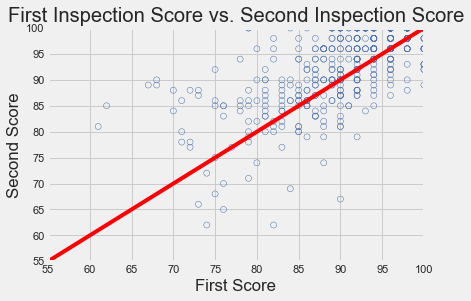

In [74]:
#scatter plot of the first vs second inspection scores
list_pairs = scores_pairs_by_business['score_pair'].tolist()
x,y = zip(*list_pairs)
plt.scatter(x , y, facecolors = 'none', edgecolors = 'b')
plt.xlabel('First Score')
plt.ylabel('Second Score')
plt.title('First Inspection Score vs. Second Inspection Score')
plt.axis(xmin = 55, xmax = 100, ymin = 55, ymax = 100)
plt.plot([55,100], [55,100], color = 'red')

If restaurants' scores tend to improve from the first to the second inspection, I would expect the points of the scatter plot to be above the line y = x, or the diagonal runnign through the center of the graph. The plot though shows a fairly equal distribution of points on both side of the line and not consistent with the tendency of scores to improve from the first to second inspection.

Text(0.5, 1.0, 'Distribution of Score Differences')

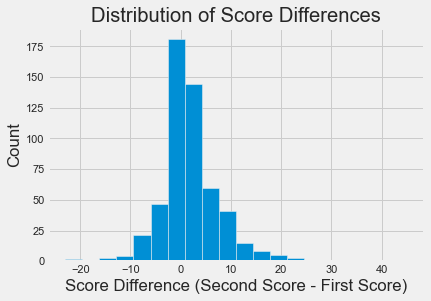

In [75]:
#distribution graph of the differences between the 2 inspection scores
differences = []
for i in list_pairs:
    differences.append(i[1] - i[0])
plt.hist(differences, bins = 20)
plt.xlabel('Score Difference (Second Score - First Score)')
plt.ylabel('Count')
plt.title('Distribution of Score Differences')

If scores improved from the first to the second inspection, I would expect that the majority of the distribution be on the positive side, or right side of 0, and the center of the distribution to be above 0. The drawn histogram shows however that the center of the distribution is at 0 and spread rougly equally the center. This is not consistent with the tendency of scores to improve from the first to second inspection.

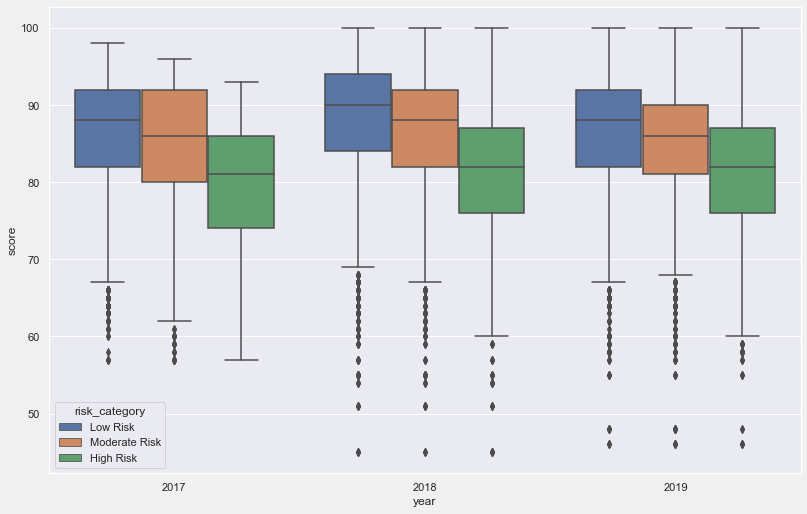

In [76]:
#Boxplot that shows the distributions of restuarant scores over time for different risk categories 2017-2019
need_ins = ins[(ins['score'] > -1) & ~(ins['year'] == 2016)][['score', 'iid','year']]
need_vio = vio[['vid','risk_category']]
mer3 = pd.merge(need_ins, ins2vio, how = 'inner', on = 'iid')
mer4 = pd.merge(mer3, need_vio, how = 'inner', on = 'vid')
mer4 = mer4[['score','risk_category','year']]

# Do not modify this line
plt.figure(figsize = (12,8))
sns.set()
ax = sns.boxplot(x='year', y='score', hue = 'risk_category', data=mer4, hue_order = ['Low Risk', 'Moderate Risk', 'High Risk'])
